## Overview 
1. Data analysis of given data
2. Check Covariance
3. ??

# 1.Data analysis of given data
The goal of this analysis is to visulaize and clean if neccessay ... 

In [1]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

# import data
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# weather data
datasets = {
    "DWD Demand": dwd_demand,
    "DWD Hornsea": dwd_hornsea,
    "DWD PES10": dwd_pes10,
    "NCEP Demand": ncep_demand,
    "NCEP Hornsea": ncep_hornsea,
    "NCEP PES10": ncep_pes10
}

# demand data
demand_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Explore data, look at variables, dimensions ect.

In [2]:
# Show variables, dimensions, shapes, and units of a dataset 
def describe_nc_dataset(dataset, dataset_name):
    print(f"\nOverview of {dataset_name}")   
    for var in dataset.variables.values():
        name = var.name 
        dims = var.dimensions
        shape = var.shape
        units = var.units if 'units' in var.ncattrs() else 'N/A'
        print(f"{name}: {dims} {shape} {units}")

for name, ds in datasets.items():
    describe_nc_dataset(ds, name)

print("n\Overview of Demand Data")
print(demand_data.info())
print(demand_data.head())


Overview of DWD Demand
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
TotalPrecipitation: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindSpeed: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
latitude: ('point',) (7,) N/A
longitude: ('point',) (7,) N/A
point: ('point',) (7,) N/A
ref_datetime: ('ref_datetime',) (4467,) hours since 2022-09-18T06:00:00
valid_datetime: ('valid_datetime',) (93,) N/A

Overview of DWD Hornsea
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection:100: ('ref_datetime', 'valid_datetime', 'latitude', 'lo

# Check Missing Values

In [7]:
def check_missing_values(dataset, dataset_name):
    print(f"\nChecking missing values for: {dataset_name}")
    has_missing = False
    
    for var_name in dataset.variables:
        var = dataset.variables[var_name]
        missing_count = pd.isnull(var[:]).sum()
        
        if missing_count > 0:
            if not has_missing:
                print("Variables with missing values:")
                has_missing = True
            print(f"- {var_name}: {missing_count} missing values")
    
    if not has_missing:
        print("No missing values found in any variable")
    
for name, dataset in datasets.items():
    check_missing_values(dataset, name)

print("\nChecking missing values for Demand Data")
print(demand_data.isnull().sum())


Checking missing values for: DWD Demand
No missing values found in any variable

Checking missing values for: DWD Hornsea
No missing values found in any variable

Checking missing values for: DWD PES10
No missing values found in any variable

Checking missing values for: NCEP Demand
No missing values found in any variable

Checking missing values for: NCEP Hornsea
No missing values found in any variable

Checking missing values for: NCEP PES10
No missing values found in any variable

Checking missing values for Demand Data
dtm                                0
MIP                              321
Solar_MW                          75
Solar_capacity_mwp                 0
Solar_installedcapacity_mwp        0
Wind_MW                          103
SS_Price                           0
boa_MWh                          103
DA_Price                           0
Unnamed: 9                     54384
Unnamed: 10                    54384
Unnamed: 11                    54384
Unnamed: 12               

# Check Time and Frequency

In [ ]:
def inspect_time(dataset, dataset_name):
    print(f"\nStart and Stop Times for {dataset_name}:")
    time_var = dataset.variables["ref_datetime"]
    print(f"Units: {time_var.units}")
    print(f"Start: {nc.num2date(time_var[0], time_var.units)}")
    print(f"End: {nc.num2date(time_var[-1], time_var.units)}")

def inspect_frequency(dataset, dataset_name):
    """Compact frequency analysis printer"""
    print(f"\nTime Measurement Frequencies for {dataset_name}:")
    diffs = pd.Series(dataset.variables["ref_datetime"][:]).diff().dropna()
    
    # Print frequency table
    for interval, count in diffs.value_counts().sort_index().items():
        print(f"{interval}: {count} occurrences")
    
    # Print quick stats
    print(f"\nTotal measurements: {len(diffs)+1}")
    print(f"Unique intervals: {diffs.nunique()}")

def find_largest_gap(dataset, dataset_name):
    print(f"\n Searching for largest time gap in {dataset_name}...")
    
    time_var = dataset.variables["ref_datetime"]
    time_vals = nc.num2date(time_var[:], units=time_var.units)

    # Convert to pandas Series for diffing
    time_series = pd.Series(time_vals)
    time_deltas = time_series.diff().dropna()

    # Find the max gap
    max_gap = time_deltas.max()
    max_gap_index = time_deltas.idxmax()

    before = time_series[max_gap_index - 1]
    after = time_series[max_gap_index]

    print(f"Largest gap: {max_gap}")
    print(f"Before: {before}")
    print(f"After:  {after}")


for name, dataset in datasets.items():
    inspect_time(dataset, name)
    inspect_frequency(dataset, name)
    find_largest_gap(dataset, name)


# Load the CSV file (replace with your actual file name)
df =  pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Convert "dtm" to datetime (ISO 8601, with UTC timezone)
df["dtm"] = pd.to_datetime(df["dtm"], utc=True)

# Sort just in case
df = df.sort_values("dtm")

# Calculate time deltas in hours
time_diffs = df["dtm"].diff().dropna().dt.total_seconds() / 3600

# Frequency summary
interval_counts = time_diffs.value_counts().sort_index()

# Display start and end times
start_time = df["dtm"].iloc[0]
end_time = df["dtm"].iloc[-1]

print(f"Start time: {start_time}")
print(f"End time:   {end_time}\n")

# Display time interval frequencies
for interval, count in interval_counts.items():
    print(f"{interval:.1f}: {int(count)} occurrences")

print(f"\nTotal measurements: {len(df)}")
print(f"Unique intervals: {interval_counts.count()}")



Start and Stop Times for DWD Demand:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-10-27 00:00:00

Time Measurement Frequencies for DWD Demand:
6.0: 4458 occurrences
12.0: 6 occurrences
18.0: 1 occurrences
330.0: 1 occurrences

Total measurements: 4467
Unique intervals: 4

 Searching for largest time gap in DWD Demand...
🚨 Largest gap: 13 days 18:00:00
Before: 2022-11-23 00:00:00
After:  2022-12-06 18:00:00

Start and Stop Times for DWD Hornsea:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-10-27 00:00:00

Time Measurement Frequencies for DWD Hornsea:
6.0: 4458 occurrences
12.0: 6 occurrences
18.0: 1 occurrences
330.0: 1 occurrences

Total measurements: 4467
Unique intervals: 4

 Searching for largest time gap in DWD Hornsea...
🚨 Largest gap: 13 days 18:00:00
Before: 2022-11-23 00:00:00
After:  2022-12-06 18:00:00

Start and Stop Times for DWD PES10:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-

# Visualize Data

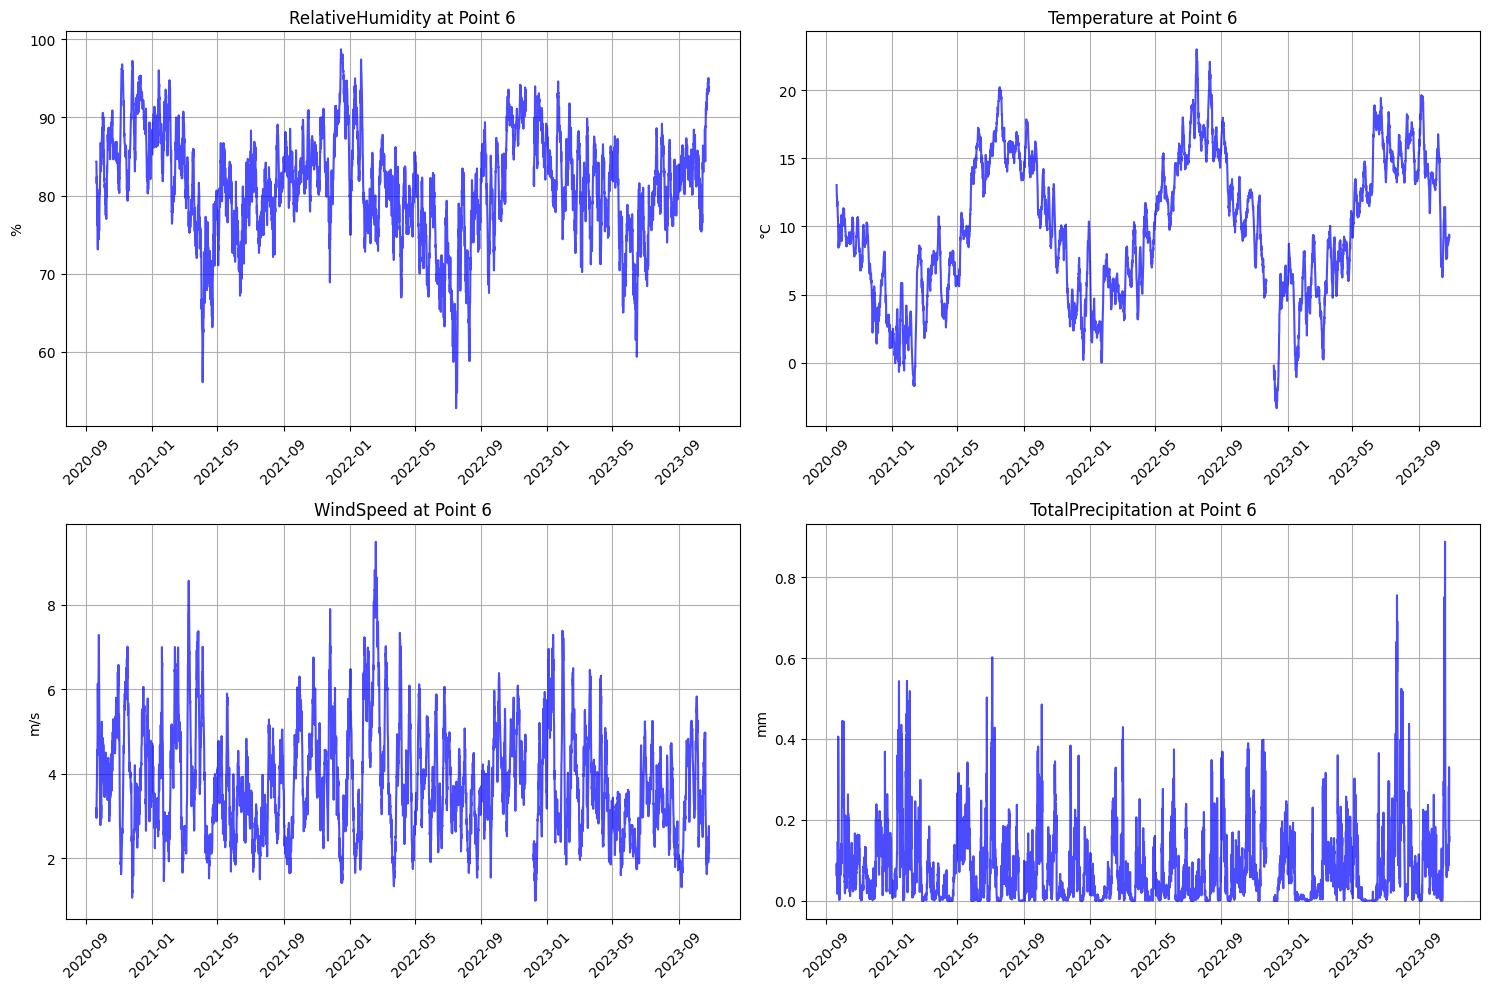

In [5]:
from datetime import datetime

# Configuration
point_idx = 6  # Which location to plot (0-6)
variables = ['RelativeHumidity', 'Temperature', 'WindSpeed', 'TotalPrecipitation']
units = ['%', '°C', 'm/s', 'mm']

# Create figure
plt.figure(figsize=(15, 10))

# Convert reference times to datetime
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# Plot each variable
for i, (var, unit) in enumerate(zip(variables, units), 1):
    # Get and aggregate data
    data = dwd_demand.variables[var][:, :, point_idx]  # [ref, valid, point]
    mean_values = np.nanmean(data, axis=1)  # Handles any NaN values
    
    # Create subplot
    plt.subplot(2, 2, i)
    plt.plot(ref_times_datetime, mean_values, 'b-', alpha=0.7)
    plt.title(f'{var} at Point {point_idx}')
    plt.ylabel(unit)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

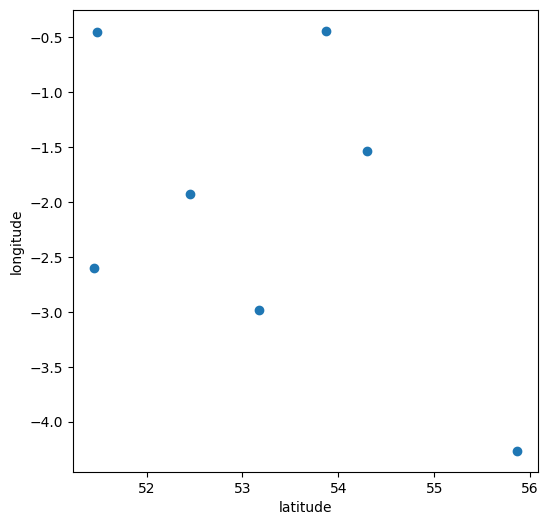

In [6]:
points = dwd_demand.variables['point'][:] # 0 1 2 3 4 5 6 
lats = dwd_demand.variables['latitude'][:]
lons = dwd_demand.variables['longitude'][:]

# Plot latitide and longitude
plt.figure(figsize=(6, 6))
plt.plot(lats, lons, 'o')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()


In [ ]:
print("start")

# extract powers
dtm_demand = demand_data["dtm"]
solar_MW_05h = demand_data["Solar_MW"]
wind_MW_05h = demand_data["Wind_MW"]
production_MW_05h = solar_MW_05h + wind_MW_05h

# look at first missing values
#first_nan_index = production_MW_05h.isna().idxmax()
#print(first_nan_index)
# Solar -> 12485
# Wind -> 20208
# Both -> 12485 

#dtm_demand.iloc[12485]
# 2021-06-07T02:30:00Z
# closest index 12480 -> 2021-06-07T00:00:00

# Readjust powers
solar_MW_6h = solar_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
wind_MW_05h = wind_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
production_MW_05h = production_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
# len ->12480/12 = 1040

# find index for weather data
#ref_times = nc.num2date(dwd_hornsea.variables['ref_datetime'][:],
#                       dwd_hornsea.variables['ref_datetime'].units)
#ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]
#print(ref_times_datetime[1034]) -> index 1034 (dwd_demand, dwd_hornsea, dwd_pes10)

point_idx = 1
weather_idx = 1040
# Fuck it use 1039 to get the vectors the same lengt
dwd_demand_RelativeHumidity = dwd_demand.variables["RelativeHumidity"][0:weather_idx, :, point_idx]
dwd_demand_Temperature = dwd_demand.variables["Temperature"][0:weather_idx, :, point_idx]
dwd_demand_TotalPrecipitation = dwd_demand.variables["TotalPrecipitation"][0:weather_idx, :, point_idx]
dwd_demand_WindDirection = dwd_demand.variables["WindDirection"][0:weather_idx, :, point_idx]
dwd_demand_WindSpeed = dwd_demand.variables["WindSpeed"][0:weather_idx, :, point_idx]

print(dwd_demand_WindSpeed.shape)
# dwd_hornsea 
dwd_pes10_CloudCover = dwd_pes10.variables["CloudCover"][0:weather_idx, :, point_idx]
dwd_pes10_SolarDownwardRadiation = dwd_pes10.variables["SolarDownwardRadiation"][0:weather_idx, :, point_idx]
dwd_pes10_Temperature = dwd_pes10.variables["Temperature"][0:weather_idx, :, point_idx]

# Step 1: Average weather data over the second axis (valid_datetime)
def avg_over_valid_dim(var):
    return var.mean(axis=1)

# Step 2: Create DataFrame
df_cov = pd.DataFrame({
    "Solar_MW": solar_MW_6h[:1040],
    "Wind_MW": wind_MW_05h[:1040],
    "Total_Production": production_MW_05h[:1040],
    "RelHumidity": avg_over_valid_dim(dwd_demand_RelativeHumidity),
    "Temp_demand": avg_over_valid_dim(dwd_demand_Temperature),
    "Precip": avg_over_valid_dim(dwd_demand_TotalPrecipitation),
    "WindDir": avg_over_valid_dim(dwd_demand_WindDirection),
    "WindSpeed": avg_over_valid_dim(dwd_demand_WindSpeed),
    "CloudCover": avg_over_valid_dim(dwd_pes10_CloudCover),
    "SolarRad": avg_over_valid_dim(dwd_pes10_SolarDownwardRadiation),
    "Temp_PES10": avg_over_valid_dim(dwd_pes10_Temperature)
})

# Step 4: Compute and visualize the covariance matrix
cov_matrix = df_cov.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix of Power Production and Weather Features")
plt.tight_layout()
plt.show()

# Preprocessing Data for Random Forest

We don't need to care about oulier data, this means we don't need to take mean or log to the data to make it more even.
To prefrocess the data we will do some data cleaning this entails fix missing values, fitt the data together so their on the same time-axis to the production time half hour resolution.   


Regarding splitting of data according to Xaviaer we could split the data at the large time gap, after the gap data will be used for training, before data will be slpit 90% for training and the last 10% for validation. Where crossvalidation will be preformed.


Other recomendations:
1. Temporal interpolation (data repair)
2. OneHotEncoder (dummy creation if needed)
3. Rekomended to use around 500 trees


In [ ]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# import data

# Weather data 
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

# Functions
def extract_variable_data(var, idx, ref_times, e_dtm):
    """
    Inputs: NC variable "var", point index "idx", referance time for variable "ref_t"
            and dtm for energy data "e_dtm"
    
    Fills in the referance times in with values from valid time (eavenly spaced),
    then use temporal interpolation to generate x2

    Returns x2 interpolated values for variable allong e_dtm axis
    """
    ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

    # alloc mem 
    n_tot = (var.shape[0])*(var.shape[1])
    values = np.empty(n_tot, dtype = "float32")
    times = np.empty(n_tot, dtype = "datetime64[ns]")

    count  = 0

    for i in range(var.shape[0]):
        # print(str(i)) if you want to se progress but slow it down 
        if i == var.shape[0]-1:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_dt_start + timedelta(hours=6)
        else:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_times_datetime[i + 1]	

        start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
        end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

        time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

        time_steps = time_steps_ns.astype('datetime64[ns]')

        # for every valid time in referance time
        for j in range(var.shape[1]):
            if var[i, j, idx] is np.ma.masked:
                values[count] = np.nan
                times[count] = time_steps[j]
                count += 1

            else: 
                values[count] = np.mean(var[i,j,idx])
                times[count] = time_steps[j]
                count += 1

    t1 = pd.to_datetime(times, utc=True)
    t2 = pd.to_datetime(e_dtm, utc=True)

    combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

    x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

    x1_reindexed = x1.reindex(combined_index)

    assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

    x1_interpolated = x1_reindexed.interpolate(method='time')

    x2 = x1_interpolated.loc[t2]

    return x2

    
# 1. Parse variables
dwd_demand_RelativeHumidity = dwd_demand["RelativeHumidity"]
dwd_demand_Temperature = dwd_demand["Temperature"]
dwd_demand_TotalPrecipitation = dwd_demand["TotalPrecipitation"]
dwd_demand_WindDirection = dwd_demand["WindDirection"]
dwd_demand_WindSpeed = dwd_demand["WindSpeed"]

dwd_hornsea_RelativeHumidity = dwd_hornsea["RelativeHumidity"]
dwd_hornsea_Temperature = dwd_hornsea["Temperature"]
dwd_hornsea_WindDirection = dwd_hornsea["WindDirection"]
dwd_hornsea_WindDirection100 = dwd_hornsea["WindDirection:100"]
dwd_hornsea_WindSpeed = dwd_hornsea["WindSpeed"]
dwd_hornsea_WindSpeed100 = dwd_hornsea["WindSpeed:100"]

dwd_pes10_CloudCover = dwd_pes10["CloudCover"]
dwd_pes10_SolarDownwardRadiation = dwd_pes10["SolarDownwardRadiation"]
dwd_pes10_Temperature = dwd_pes10["Temperature"]

ncep_demand_RelativeHumidity = ncep_demand["RelativeHumidity"]
ncep_demand_Temperature = ncep_demand["Temperature"]
ncep_demand_TotalPrecipitation = ncep_demand["TotalPrecipitation"]
ncep_demand_WindDirection = ncep_demand["WindDirection"]
ncep_demand_WindSpeed = ncep_demand["WindSpeed"]

ncep_hornsea_RelativeHumidity = ncep_hornsea["RelativeHumidity"]
ncep_hornsea_Temperature = ncep_hornsea["Temperature"]
ncep_hornsea_WindDirection = ncep_hornsea["WindDirection"]
ncep_hornsea_WindDirection100 = ncep_hornsea["WindDirection:100"]
ncep_hornsea_WindSpeed = ncep_hornsea["WindSpeed"]
ncep_hornsea_WindSpeed100 = ncep_hornsea["WindSpeed:100"]

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)

# Now comes the shit of handeling the weather data


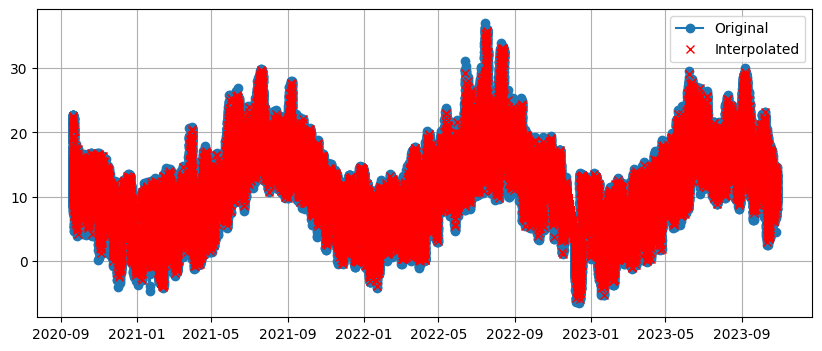

In [ ]:
# Test block for function

# Inputs 
idx = 1 
var = dwd_demand_Temperature
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# alloc mem 
n_tot = (var.shape[0])*(var.shape[1])
values = np.empty(n_tot, dtype = "float32")
times = np.empty(n_tot, dtype = "datetime64[ns]")

count  = 0

# for every referance time
for i in range(var.shape[0]):
    # print(str(i)) if you want to se progress but slow it down 
    if i == var.shape[0]-1:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_dt_start + timedelta(hours=6)
    else:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_times_datetime[i + 1]	

    # Convert to datetime64[ns] explicitly
    start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
    end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

    # Generate linear space in nanoseconds
    time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

    # Convert back to datetime64[ns]
    time_steps = time_steps_ns.astype('datetime64[ns]')

    # for every valid time in referance time
    for j in range(var.shape[1]):
        if var[i, j, idx] is np.ma.masked:
            values[count] = np.nan
            times[count] = time_steps[j]
            count += 1

        else: 
            values[count] = np.mean(var[i,j,idx])
            times[count] = time_steps[j]
            count += 1

t1 = pd.to_datetime(times, utc=True)
t2 = pd.to_datetime(energy_data_dtm, utc=True)

# Combine and sort unique timestamps
combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

# Create the Series with t1
x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

# Reindex to combined time axis
x1_reindexed = x1.reindex(combined_index)

# Check to make sure it's still a DatetimeIndex
assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

# Interpolate
x1_interpolated = x1_reindexed.interpolate(method='time')

# Extract the values at your target timestamps
x2 = x1_interpolated.loc[t2]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(x1.index, x1.values, 'o-', label='Original')
plt.plot(x2.index, x2.values, 'xr', label='Interpolated')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)

result = extract_variable_data(var = dwd_demand_Temperature,
    idx = 1,
    ref_times = test,
    e_dtm = energy_data_dtm)



# This is great and all I've done is enter my name, Thillho 
## ~ Milhouse Mussolini Van Houten

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
#import tensorflow as tf 
#import keras
import matplotlib.pyplot as plt

# Loacal funcions
def interpolate_weather_variable(ds, var_name, point_idx, energy_data_dtm):
    """
    Interpolates a weather variable from an xarray.Dataset to match energy data timestamps.

    Parameters:
        ds (xarray.Dataset): The dataset containing weather data.
        var_name (str): Name of the variable in ds (e.g., "Temperature").
        point_idx (int): Index of the point to extract.
        energy_data_dtm (array-like): Timestamps of energy data.

    Returns:
        pd.Series: Interpolated weather variable values aligned with energy_data_dtm.
    """
    # Extract variable values and associated times
    var = ds[var_name][:, :, point_idx].values
    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values  # hours ahead

    # Flatten into timestamp-value pairs
    all_datetimes = []
    all_values = []
    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]
            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    # Make sure energy timestamps are a proper DatetimeIndex
    energy_timestamps = pd.to_datetime(energy_data_dtm)
    energy_timestamps = pd.DatetimeIndex(energy_timestamps).tz_localize(None)

    # Create initial Series
    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)

    # Average duplicates (if any)
    ts = ts.groupby(ts.index).mean()

    # Combine, sort and interpolate
    combined_index = pd.DatetimeIndex(ts.index.union(energy_timestamps)).sort_values()
    ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

    # Return only the values aligned with energy timestamps
    return ts_interpolated.loc[energy_timestamps]

def interpolate_var_flexible(ds, var_name, energy_data_dtm, lat_idx=None, lon_idx=None):
    """
    Interpolates a lat-lon-based weather variable to match energy data timestamps.

    Parameters:
        ds (xarray.Dataset): The dataset containing the variable.
        var_name (str): Variable name to interpolate.
        energy_data_dtm (array-like): Target timestamps (from energy data).
        lat_idx (int, optional): Index of latitude to extract. Required if not doing diagonal.
        lon_idx (int, optional): Index of longitude to extract. Required if not doing diagonal.

    Returns:
        pd.Series or pd.DataFrame: Interpolated time-aligned Series or DataFrame (if diagonal).
    """
    energy_timestamps = pd.to_datetime(energy_data_dtm)
    energy_timestamps = pd.DatetimeIndex(energy_timestamps).tz_localize(None)

    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values  # hours ahead

    # Handle diagonal case if no specific lat/lon is passed
    if lat_idx is None and lon_idx is None:
        lat_len = ds.dims["latitude"]
        lon_len = ds.dims["longitude"]
        assert lat_len == lon_len, "Latitude and longitude dimensions must match for diagonal extraction."

        df = pd.DataFrame(index=energy_timestamps)

        for idx in range(lat_len):
            var = ds[var_name][:, :, idx, idx].values  # diagonal extraction
            all_datetimes = []
            all_values = []

            for i, ref_time in enumerate(ref_times):
                for j, offset in enumerate(valid_offsets):
                    forecast_time = ref_time + pd.Timedelta(hours=int(offset))
                    value = var[i, j]
                    if not np.isnan(value):
                        all_datetimes.append(forecast_time)
                        all_values.append(value)

            ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)
            ts = ts.groupby(ts.index).mean()
            combined_index = ts.index.union(energy_timestamps).sort_values()
            ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

            df[f"{var_name}_P{idx}"] = ts_interpolated.loc[energy_timestamps].values

        return df

    # Else, handle single point selection (lat_idx and lon_idx must be provided)
    var = ds[var_name][:, :, lat_idx, lon_idx].values  # (ref_datetime, valid_datetime)
    all_datetimes = []
    all_values = []

    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]
            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)
    ts = ts.groupby(ts.index).mean()
    combined_index = ts.index.union(energy_timestamps).sort_values()
    ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

    return ts_interpolated.loc[energy_timestamps]

dwd_demand = xr.open_dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = xr.open_dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = xr.open_dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = xr.open_dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

weather_config = [
    {
        "name": "dwd_demand",
        "ds": dwd_demand,
        "vars": ["RelativeHumidity", "Temperature", "TotalPrecipitation", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "dwd_hornsea",
        "ds": dwd_hornsea,
        "vars": ["RelativeHumidity", "Temperature", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "dwd_pes10",
        "ds": dwd_pes10,
        "vars": ["CloudCover", "SolarDownwardRadiation", "Temperature"],
        "index": "all_points"
    },
    {
        "name": "ncep_demand",
        "ds": ncep_demand,
        "vars": ["RelativeHumidity", "Temperature", "TotalPrecipitation", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "ncep_hornsea",
        "ds": ncep_hornsea,
        "vars": ["RelativeHumidity", "Temperature", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "ncep_pes10",
        "ds": ncep_pes10,
        "vars": ["CloudCover", "SolarDownwardRadiation", "Temperature"],
        "index": "all_points"
    },
]

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)


In [6]:
ds

<xarray.Dataset> Size: 70MB
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 56B ...
    longitude           (point) float64 56B ...
  * point               (point) int64 56B 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 36kB 2020-09-20 ... 202...
  * valid_datetime      (valid_datetime) int64 744B 0 1 2 3 ... 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 12MB ...
    Temperature         (ref_datetime, valid_datetime, point) float32 12MB ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 23MB ...
    WindDirection       (ref_datetime, valid_datetime, point) float32 12MB ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 12MB ...

In [15]:
    point_idx = 1
    var = ds["Temperature"][:, :, point_idx].values  # shape: (ref_datetime, valid_datetime)
    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values       # e.g., [0, 1, ..., 120]
    
    all_datetimes = []
    all_values = []

    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]

            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    # Make sure energy timestamps are a proper DatetimeIndex
    energy_data_dtm = pd.to_datetime(energy_data_dtm)
    if isinstance(energy_data_dtm, pd.Series):
        energy_data_dtm = energy_data_dtm.values  # remove name if present
    energy_timestamps = pd.DatetimeIndex(energy_data_dtm).tz_localize(None)

    # Create the Series (already using DatetimeIndex)
    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)

    # Remove duplicates by averaging
    ts = ts.groupby(ts.index).mean()

    # Combine and reindex
    combined_index = ts.index.union(energy_timestamps)
    combined_index = pd.DatetimeIndex(combined_index).sort_values()

    # Now safe to interpolate
    ts_reindexed = ts.reindex(combined_index)
    ts_interpolated = ts_reindexed.interpolate(method='time')

    # Final selection at target timestamps
    ts_final = ts_interpolated.loc[energy_timestamps]



In [ ]:
# Example usage of fucntion to dataframe
#test = interpolate_weather_variable(ds, "Temperature", point_idx, energy_data_dtm)

weather_features = pd.DataFrame(index=pd.to_datetime(energy_data_dtm))

for cfg in weather_config:
    ds = cfg["ds"]
    for var in cfg["vars"]:
        try:
            data_array = ds[var]
            dims = data_array.dims

            # If variable has 'point' dimension
            if "point" in dims and cfg["index"] == "all_points":
                num_points = data_array.sizes["point"]
                for p in range(num_points):
                    print(f"Interpolating {cfg['name']} - {var} - Point {p}")
                    s = interpolate_weather_variable(ds, var, p, energy_data_dtm)
                    col_name = f"{cfg['name']}_{var}_P{p}"
                    weather_features[col_name] = s.values

            # If it's a lat-lon grid, loop over all lat-lon combos
            elif "latitude" in dims and "longitude" in dims and cfg["index"] == "all_points":
                num_lat = data_array.sizes["latitude"]
                num_lon = data_array.sizes["longitude"]
                for lat_idx in range(num_lat):
                    for lon_idx in range(num_lon):
                        print(f"Interpolating {cfg['name']} - {var} - Lat {lat_idx}, Lon {lon_idx}")
                        s = interpolate_var_flexible(ds, var, energy_data_dtm,
                                                     lat_idx=lat_idx, lon_idx=lon_idx)
                        col_name = f"{cfg['name']}_{var}_Lat{lat_idx}_Lon{lon_idx}"
                        weather_features[col_name] = s.values

            else:
                # Fallback to single-point extraction
                print(f"Interpolating {cfg['name']} - {var} - Default point")
                s = interpolate_weather_variable(ds, var, point_idx=0, energy_data_dtm=energy_data_dtm)
                col_name = f"{cfg['name']}_{var}"
                weather_features[col_name] = s.values

        except Exception as e:
            print(f"⚠️ Skipped {cfg['name']} - {var}: {e}")


In [4]:
print(weather_features.shape)
print(weather_features.head())
print(weather_features.info())  
temp0 = weather_features

(54384, 370)
                           dwd_demand_RelativeHumidity_P0  \
dtm                                                         
2020-09-20 00:00:00+00:00                       85.221611   
2020-09-20 00:30:00+00:00                       87.215004   
2020-09-20 01:00:00+00:00                       89.208397   
2020-09-20 01:30:00+00:00                       90.462845   
2020-09-20 02:00:00+00:00                       91.717285   

                           dwd_demand_RelativeHumidity_P1  \
dtm                                                         
2020-09-20 00:00:00+00:00                       83.608330   
2020-09-20 00:30:00+00:00                       84.916176   
2020-09-20 01:00:00+00:00                       86.224022   
2020-09-20 01:30:00+00:00                       87.004837   
2020-09-20 02:00:00+00:00                       87.785645   

                           dwd_demand_RelativeHumidity_P2  \
dtm                                                         
2020-09-2

In [23]:
#weather_features.to_csv("weather_features.csv", index=True)



In [26]:
import pandas as pd
import numpy as np
import netCDF4 as nc


energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# Konvertera "dtm" till datetime
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"], utc=True)

# Exakt tid med halvtimme
energy_data["hour_exact"] = energy_data["dtm"].dt.hour + energy_data["dtm"].dt.minute / 60

# Cyklisk tid (med halvtimme med i beräkningen)
energy_data["hour_sin"] = np.sin(2 * np.pi * energy_data["hour_exact"] / 24)
energy_data["hour_cos"] = np.cos(2 * np.pi * energy_data["hour_exact"] / 24)


# Extrahera tidskomponenter
energy_data["hour"] = energy_data["dtm"].dt.hour
energy_data["weekday"] = energy_data["dtm"].dt.weekday
energy_data["month"] = energy_data["dtm"].dt.month


energy_data["weekday_sin"] = np.sin(2 * np.pi * energy_data["weekday"] / 7)
energy_data["weekday_cos"] = np.cos(2 * np.pi * energy_data["weekday"] / 7)

energy_data["month_sin"] = np.sin(2 * np.pi * energy_data["month"] / 12)
energy_data["month_cos"] = np.cos(2 * np.pi * energy_data["month"] / 12)

def cyclic_time_from_nc(nc_dataset):
    time_var = nc_dataset.variables["ref_datetime"]
    times_raw = nc.num2date(time_var[:], units=time_var.units)

    # Konvertera varje cftime till pandas-vänlig Timestamp
    times = [pd.Timestamp(t.isoformat()) for t in times_raw]

    hour = [t.hour for t in times]
    weekday = [t.weekday() for t in times]
    month = [t.month for t in times]

    df = pd.DataFrame({
        "ref_datetime": times,
        "hour": hour,
        "hour_sin": np.sin(2 * np.pi * np.array(hour) / 24),
        "hour_cos": np.cos(2 * np.pi * np.array(hour) / 24),
        "weekday": weekday,
        "weekday_sin": np.sin(2 * np.pi * np.array(weekday) / 7),
        "weekday_cos": np.cos(2 * np.pi * np.array(weekday) / 7),
        "month": month,
        "month_sin": np.sin(2 * np.pi * np.array(month) / 12),
        "month_cos": np.cos(2 * np.pi * np.array(month) / 12),
    })

    return df


cyclic_dwd_demand = cyclic_time_from_nc(dwd_demand)
cyclic_dwd_hornsea = cyclic_time_from_nc(dwd_hornsea)
cyclic_dwd_pes10 = cyclic_time_from_nc(dwd_pes10)
cyclic_ncep_demand = cyclic_time_from_nc(ncep_demand)
cyclic_ncep_hornsea = cyclic_time_from_nc(ncep_hornsea)
cyclic_ncep_pes10 = cyclic_time_from_nc(ncep_pes10)


print(energy_data[["dtm", "hour_exact", "hour_sin", "hour_cos"]].head(10))


cyclic_dfs = {
    "cyclic_dwd_demand": cyclic_dwd_demand,
    "cyclic_dwd_hornsea": cyclic_dwd_hornsea,
    "cyclic_dwd_pes10": cyclic_dwd_pes10,
    "cyclic_ncep_demand": cyclic_ncep_demand,
    "cyclic_ncep_hornsea": cyclic_ncep_hornsea,
    "cyclic_ncep_pes10": cyclic_ncep_pes10
}

for name, df in cyclic_dfs.items():
    print(f"\n {name}")
    print(f"- Antal rader: {len(df)}")
    print(f"- Kolumner: {df.columns.tolist()}")
    print(f"- Tidsintervall: {df['ref_datetime'].min()} → {df['ref_datetime'].max()}")
    print("- Första 3 rader:")
    print(df.head(3))

#print(cyclic_dwd_hornsea.head())

                        dtm  hour_exact  hour_sin  hour_cos
0 2020-09-20 00:00:00+00:00         0.0  0.000000  1.000000
1 2020-09-20 00:30:00+00:00         0.5  0.130526  0.991445
2 2020-09-20 01:00:00+00:00         1.0  0.258819  0.965926
3 2020-09-20 01:30:00+00:00         1.5  0.382683  0.923880
4 2020-09-20 02:00:00+00:00         2.0  0.500000  0.866025
5 2020-09-20 02:30:00+00:00         2.5  0.608761  0.793353
6 2020-09-20 03:00:00+00:00         3.0  0.707107  0.707107
7 2020-09-20 03:30:00+00:00         3.5  0.793353  0.608761
8 2020-09-20 04:00:00+00:00         4.0  0.866025  0.500000
9 2020-09-20 04:30:00+00:00         4.5  0.923880  0.382683

 cyclic_dwd_demand
- Antal rader: 4467
- Kolumner: ['ref_datetime', 'hour', 'hour_sin', 'hour_cos', 'weekday', 'weekday_sin', 'weekday_cos', 'month', 'month_sin', 'month_cos']
- Tidsintervall: 2020-09-20 00:00:00 → 2023-10-27 00:00:00
- Första 3 rader:
         ref_datetime  hour      hour_sin      hour_cos  weekday  weekday_sin  \
0 202